In [5]:
# 📥 Step 1: Load Dataset
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the dataset
data = pd.read_csv(r"C:\Users\Bharathan\Desktop\Bharathan_POC\Bank_Transaction_Fraud_Detection.csv")
print("Dataset Shape:", data.shape)
data.head()


Dataset Shape: (200000, 24)


,Customer_ID,Customer_Name,Gender,Age,State,City,Bank_Branch,Account_Type,Transaction_ID,Transaction_Date,...,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Currency,Customer_Contact,Transaction_Description,Customer_Email
0,d5f6ec07-d69e-4f47-b9b4-7c58ff17c19e,Osha Tella,Male,60,Kerala,Thiruvananthapuram,Thiruvananthapuram Branch,Savings,4fa3208f-9e23-42dc-b330-844829d0c12c,23-01-2025,...,Restaurant,74557.27,Voice Assistant,"Thiruvananthapuram, Kerala",POS,0,INR,+9198579XXXXXX,Bitcoin transaction,oshaXXXXX@XXXXX.com
1,7c14ad51-781a-4db9-b7bd-67439c175262,Hredhaan Khosla,Female,51,Maharashtra,Nashik,Nashik Branch,Business,c9de0c06-2c4c-40a9-97ed-3c7b8f97c79c,11-01-2025,...,Restaurant,74622.66,POS Mobile Device,"Nashik, Maharashtra",Desktop,0,INR,+9191074XXXXXX,Grocery delivery,hredhaanXXXX@XXXXXX.com
2,3a73a0e5-d4da-45aa-85f3-528413900a35,Ekani Nazareth,Male,20,Bihar,Bhagalpur,Bhagalpur Branch,Savings,e41c55f9-c016-4ff3-872b-cae72467c75c,25-01-2025,...,Groceries,66817.99,ATM,"Bhagalpur, Bihar",Desktop,0,INR,+9197745XXXXXX,Mutual fund investment,ekaniXXX@XXXXXX.com
3,7902f4ef-9050-4a79-857d-9c2ea3181940,Yamini Ramachandran,Female,57,Tamil Nadu,Chennai,Chennai Branch,Business,7f7ee11b-ff2c-45a3-802a-49bc47c02ecb,19-01-2025,...,Entertainment,58177.08,POS Mobile App,"Chennai, Tamil Nadu",Mobile,0,INR,+9195889XXXXXX,Food delivery,yaminiXXXXX@XXXXXXX.com
4,3a4bba70-d9a9-4c5f-8b92-1735fd8c19e9,Kritika Rege,Female,43,Punjab,Amritsar,Amritsar Branch,Savings,f8e6ac6f-81a1-4985-bf12-f60967d852ef,30-01-2025,...,Entertainment,16108.56,Virtual Card,"Amritsar, Punjab",Mobile,0,INR,+9195316XXXXXX,Debt repayment,kritikaXXXX@XXXXXX.com


In [17]:
# ⚙️ Step 2: Optional Sampling for Faster Processing
# Use 20% for quick experimentation (optional)
data = data.sample(frac=0.2, random_state=42).reset_index(drop=True)
print(data.columns.tolist())


['Customer_ID', 'Customer_Name', 'Gender', 'Age', 'State', 'City', 'Bank_Branch', 'Account_Type', 'Transaction_ID', 'Transaction_Date', 'Transaction_Time', 'Transaction_Amount', 'Merchant_ID', 'Transaction_Type', 'Merchant_Category', 'Account_Balance', 'Transaction_Device', 'Transaction_Location', 'Device_Type', 'Is_Fraud', 'Transaction_Currency', 'Customer_Contact', 'Transaction_Description', 'Customer_Email']


C:\Users\Bharathan\AppData\Local\Temp\ipykernel_2360\3543863197.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['Is_Fraud'], palette="coolwarm")


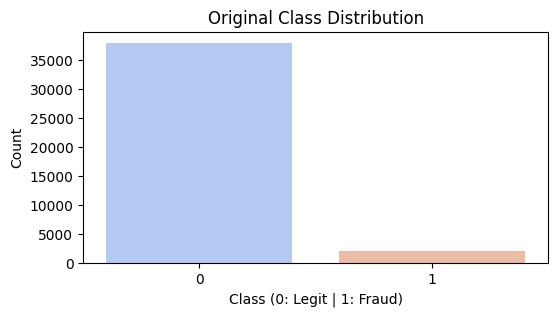

In [8]:
# 📊 Visualize Class Distribution Before Balancing
plt.figure(figsize=(6,3))
sns.countplot(x=data['Is_Fraud'], palette="coolwarm")
plt.title("Original Class Distribution")
plt.xlabel("Class (0: Legit | 1: Fraud)")
plt.ylabel("Count")
plt.show()


In [9]:
import networkx as nx

# 🔗 Step 3: Build Transaction Graph
G = nx.Graph()

for _, row in data.iterrows():
    txn_id = row['Transaction_ID']
    cust_id = f"Cust_{row['Customer_ID']}"
    merch_id = f"Merch_{row['Merchant_ID']}"

    # Add nodes
    G.add_node(cust_id, type="Customer")
    G.add_node(merch_id, type="Merchant")
    G.add_node(txn_id, type="Transaction", fraud=row['Is_Fraud'], amount=row['Transaction_Amount'])

    # Add edges
    G.add_edge(cust_id, txn_id, relationship="initiated")
    G.add_edge(txn_id, merch_id, relationship="processed_by")


In [10]:
# 📊 Step 4: Extract Graph Features
pagerank_scores = nx.pagerank(G)
clustering_scores = nx.clustering(G)

features = []
labels = []

for _, row in data.iterrows():
    txn_id = row['Transaction_ID']
    amount = row['Transaction_Amount']
    
    pagerank = pagerank_scores.get(txn_id, 0)
    degree = G.degree(txn_id)
    clustering = clustering_scores.get(txn_id, 0)
    
    features.append([pagerank, degree, clustering, amount])
    labels.append(row['Is_Fraud'])

# Convert to DataFrame
df_features = pd.DataFrame(features, columns=["PageRank", "Degree", "Clustering", "Amount"])
df_labels = pd.Series(labels, name="Fraud")


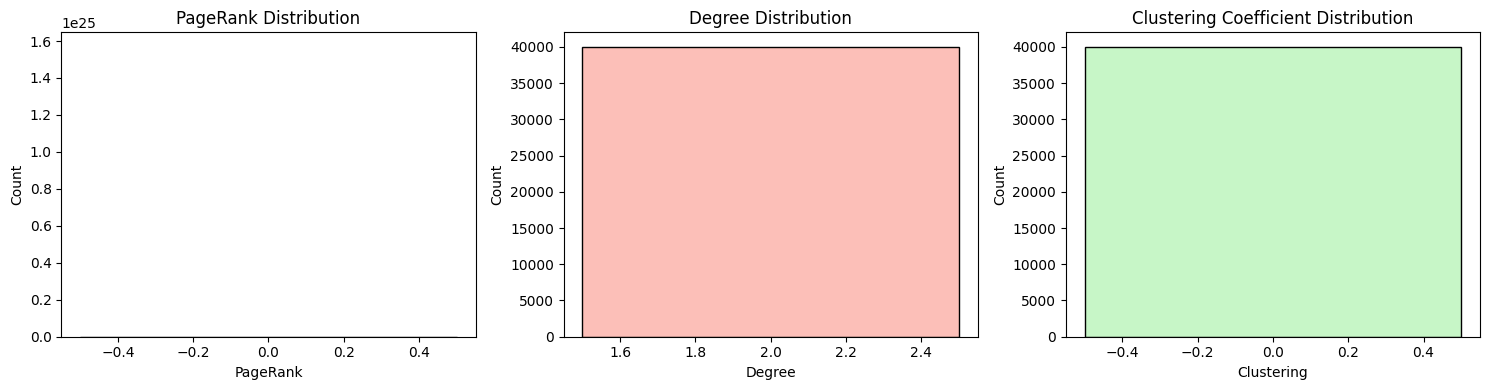

In [11]:
# 📉 Distribution of Graph-Based Features
fig, axs = plt.subplots(1, 3, figsize=(15,4))

sns.histplot(df_features["PageRank"], kde=True, ax=axs[0], color='skyblue')
axs[0].set_title("PageRank Distribution")

sns.histplot(df_features["Degree"], kde=True, ax=axs[1], color='salmon')
axs[1].set_title("Degree Distribution")

sns.histplot(df_features["Clustering"], kde=True, ax=axs[2], color='lightgreen')
axs[2].set_title("Clustering Coefficient Distribution")

plt.tight_layout()
plt.show()


In [12]:
# 🤖 Step 5: Train Random Forest Classifier
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

✅ Accuracy: 0.9013333333333333

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     11415
           1       0.04      0.05      0.04       585

    accuracy                           0.90     12000
   macro avg       0.50      0.50      0.50     12000
weighted avg       0.91      0.90      0.90     12000



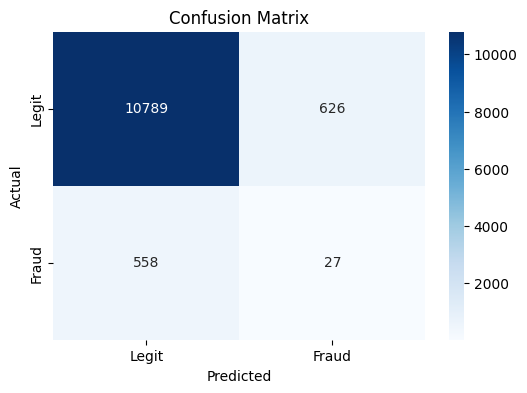

In [13]:
# 📈 Step 6: Evaluate Model Performance
y_pred = clf.predict(X_test)

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Legit", "Fraud"], yticklabels=["Legit", "Fraud"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


✅ Tuned Accuracy: 0.9094166666666667

📋 Tuned Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     11415
           1       0.04      0.04      0.04       585

    accuracy                           0.91     12000
   macro avg       0.50      0.50      0.50     12000
weighted avg       0.91      0.91      0.91     12000



C:\Users\Bharathan\AppData\Local\Temp\ipykernel_2360\757498041.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette="crest")


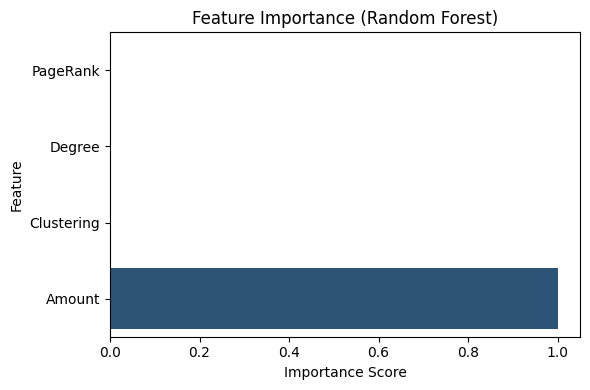

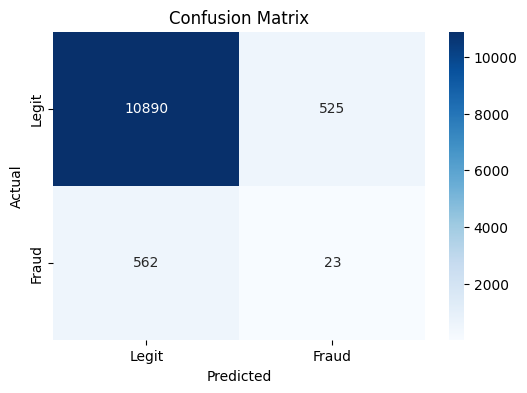

In [ ]:
#🔍 Step 7: Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
clf_best = grid_search.best_estimator_

# Prediction using best estimator
y_pred = clf_best.predict(X_test)

print("✅ Tuned Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Tuned Classification Report:\n", classification_report(y_test, y_pred))
# 📈 Feature Importance Visualization
importances = clf_best.feature_importances_
feature_names = df_features.columns

plt.figure(figsize=(6,4))
sns.barplot(x=importances, y=feature_names, palette="crest")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Legit", "Fraud"], yticklabels=["Legit", "Fraud"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


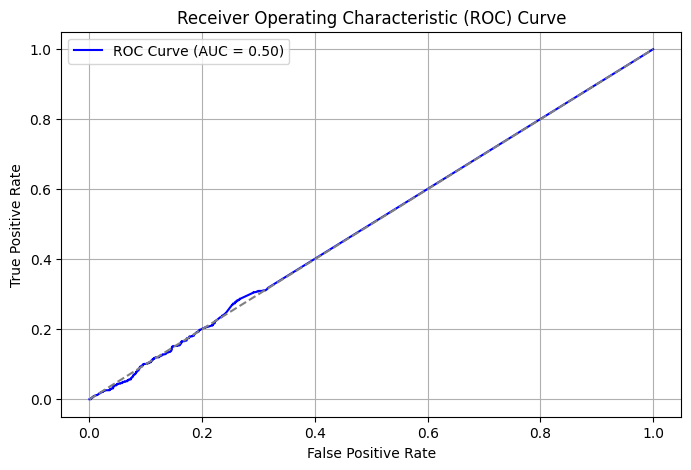

In [ ]:
# Predict probabilities for ROC
from sklearn.metrics import roc_curve, roc_auc_score
y_probs = clf_best.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# Plot ROC Curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle='--', color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid(True)
plt.show()


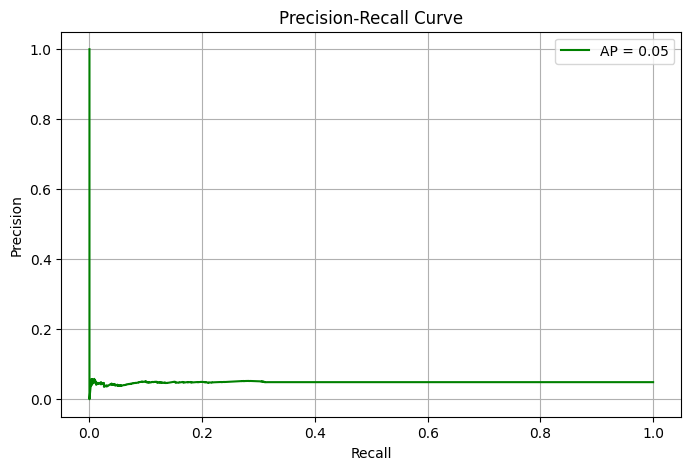

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get precision-recall values
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

# Plot precision-recall curve
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label=f"AP = {avg_precision:.2f}", color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.show()
